# How many remain?

The question we try to answer here is: Suppose that on a given day we observe $k$ new infections, how many exposed (infected but not infectious) individuals remain in the population? We do this as follows, using "reasonable" values of the epidemic rate parameters and a physical distancing network model fitted to the observed time series data we simulate a large ($N=100$ - or maybe more, once I gt it working) number of dynamics and read-off the infected and exposed nubers in the tail of the transmission urve to get a conditional PDF - the final figure.

## Load in the data and define the various parameters:

Find the point of inflection (what is called turning point below) in the total nmber of infections

In [24]:
cd("/Users/michael/work/GitHub/epinets")
include("EpiSim.jl")
using CSV
using Plots
using LightGraphs
using JLD2, FileIO
cd("/Users/michael/work/GitHub/COVID-19/csse_covid_19_data/csse_covid_19_time_series")
file="time_series_covid19_confirmed_global.csv"
allstates=["Australian Capital Territory" "New South Wales"  "Northern Territory" "Queensland" "South Australia" "Tasmania" "Victoria" "Western Australia"]
allcities=["Canberra" "Sydney" "Darwin" "Brisbane" "Adelaide" "Hobart" "Melbourne" "Perth"]
z=[]
for state in allstates
    z=push!(z,EpiSim.getdata("Australia",state))
end
ddays=CSV.File(file)[1]
ddays=propertynames(ddays,4)[5:end]
ddays=String.(ddays)
ndays=length(ddays)
pops=[426709 8089526 245869 5095100 1751693 534281 6594804 2621680]
cpop=[447457 4741874 132708 2326656 1315346 208324 4677157 2004696]
#'reasonable' parameters
epiparam=Dict()
epiparam["p0"]=0.2 #a guess - tuned to match observed data 
epiparam["p2"]=1/12 #revised infection rate with distancing measure
epiparam["q"]=1/7 #"up to" two weeks
epiparam["r0"]=1/14 #about two weeks for mild, 3-6 for severe
epiparam["r2"]=1/4 #revised removal rate (now due to testing and isolation)
epiparam["nseeds"]=5 #probably too many, consider dropping.

5

## Simulate with isolation 

In [25]:
i=8 # Perth
epiparam["pop"]=pops[i]
epiparam["gridsize"]=Int(floor(sqrt(pops[i])))
y=z[i];
ddt(z,zt)=count(z->z>0, z[1:zt])+ count(z->z<0, z[zt+1:end])
~,tpday=findmax([ddt(diff(diff(y)),nx) for nx in 1:(ndays-2)])
#this is the turning point between exponential growth and decay. totItp total infections at day tpday
totItp=y[tpday+1]
plot(1:tpday+1,y[1:tpday+1],lw=4,label="growth phase",title=allstates[i])
plot!(tpday+1:ndays,y[tpday+1:ndays],lw=4,label="plateau")
cd("/Users/michael/work/GitHub/epinets")

In [26]:
gridsize=epiparam["gridsize"]
pop=epiparam["pop"]
bamodel=barabasi_albert(gridsize^2, 3, 2)
lattice=LightGraphs.grid((gridsize,gridsize),periodic=true)
wattstrog95=watts_strogatz(gridsize^2, 4, 0.013)  #s=0.013 => 95% compliance
wattstrog90=watts_strogatz(gridsize^2, 4, 0.026)  #s=0.026 => 90% compliance
wattstrog80=watts_strogatz(gridsize^2, 4, 0.053)  #s=0.053 => 80% compliance
St95,Et95,It95,Rt95=EpiSim.episim(bamodel,wattstrog95, epiparam, totItp, tpday+2, 90, 100)
St90,Et90,It90,Rt90=EpiSim.episim(bamodel,wattstrog90, epiparam, totItp, tpday+2, 90, 100)
St80,Et80,It80,Rt80=EpiSim.episim(bamodel,wattstrog80, epiparam, totItp, tpday+2, 90, 100)

100.0%┣████████████████████████████████████████┫ 100/100 [14:47<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [16:04<00:00, 0.1 it/s]
100.0%┣████████████████████████████████████████┫ 100/100 [18:51<00:00, 0.1 it/s]


(UInt64[0x00000000002800f0 0x00000000002800f0 … 0x00000000002800f0 0x00000000002800f0; 0x00000000002800f0 0x00000000002800f0 … 0x00000000002800f0 0x00000000002800f0; … ; 0x000000000027fc55 0x000000000027fd7d … 0x000000000027fd19 0x000000000027f8ac; 0x000000000027fc55 0x000000000027fd7d … 0x000000000027fd19 0x000000000027f8ac], UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x0000000000000009 0x0000000000000003 … 0x0000000000000008 0x000000000000000a; 0x0000000000000008 0x0000000000000003 … 0x0000000000000007 0x0000000000000008], UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x0000000000000002 0x0000000000000001 … 0x0000000000000005 0x0000000000000007; 0x0000000000000003 0x0000000000000000 … 0x0000000000000004 0x0000000000000008], UInt64[0x000000

## And plot
... for Melbourne ...

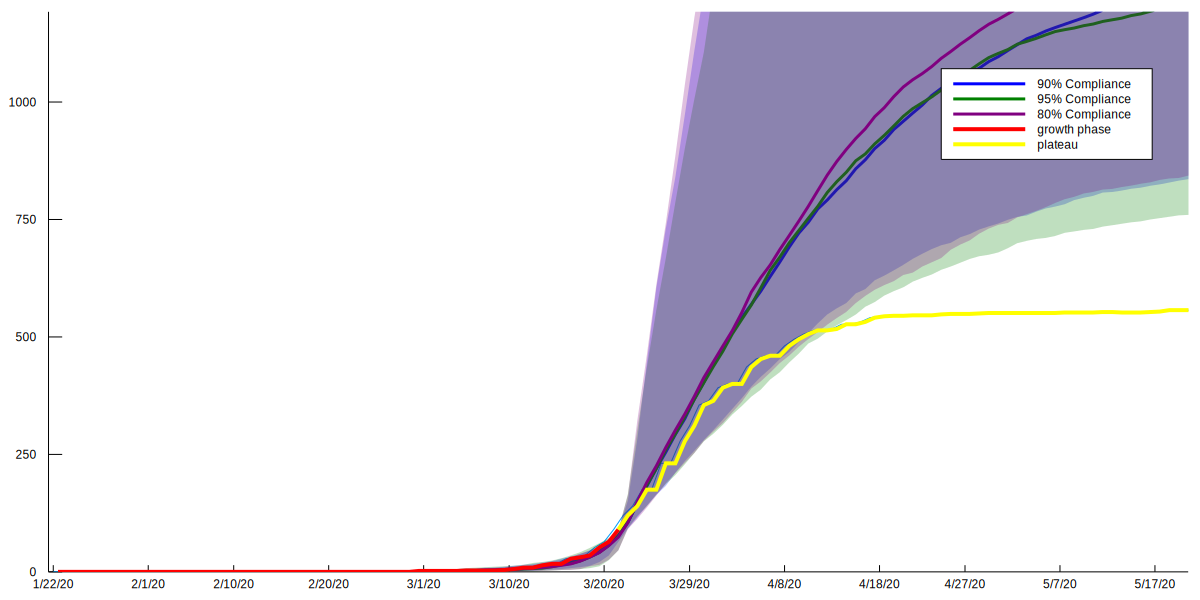

In [27]:
plot(ddays,y,size=(1200,600),label=false)
EpiSim.plotquantiles(pop .- (Et90+St90),:blue,"90% Compliance")
EpiSim.plotquantiles(pop .- (Et95+St95),:green,"95% Compliance")
EpiSim.plotquantiles(pop .- (Et80+St80),:purple,"80% Compliance")
plot!(1:tpday+1,y[1:tpday+1],lw=4, color=:red,label="growth phase")
plot!(tpday+1:ndays,y[tpday+1:ndays],color=:yellow,lw=4,label="plateau",xlim=(0, 120), ylim=(0,2*y[end]))

## Enforce still stricter isolation

First set up the required network with isolated nodes (iso), then, simulate and plot everything.

In [28]:
iso=0.8 #was 0.95, I think 0.8 should be enough ... actually this parameter *may* significantly affect the results as it determines the susceptible pool size
pop=epiparam["pop"]
grd=Int(floor(sqrt(Int(floor(pop*(1-iso))))))
isosize=pop-grd^2
sg=SimpleGraph(isosize)
ws=watts_strogatz(grd^2, 4, 0.026)
isograph90=union(sg,ws)
Int(floor(sqrt(Int(floor(pop*(1-iso))))))

724

In [29]:
St9,Et9,It9,Rt9=EpiSim.episim3(bamodel,wattstrog90, isograph90, epiparam, totItp, tpday+2, 1, 180, 400)

100.0%┣█████████████████████████████████████┫ 400/400 [01:04:36<00:00, 0.1 it/s]


(UInt64[0x00000000002800f0 0x00000000002800f0 … 0x00000000002800f0 0x00000000002800f0; 0x00000000002800f0 0x00000000002800f0 … 0x00000000002800f0 0x00000000002800f0; … ; 0x000000000027fd22 0x000000000027fe5b … 0x000000000027feb2 0x000000000027fdbd; 0x000000000027fd22 0x000000000027fe5b … 0x000000000027feb2 0x000000000027fdbd], UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x000000000000002a 0x000000000000000d … 0x000000000000001f 0x0000000000000028; 0x000000000000002a 0x000000000000000d … 0x000000000000001f 0x0000000000000028], UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x0000000000000016 0x0000000000000008 … 0x0000000000000014 0x000000000000000c; 0x0000000000000016 0x0000000000000008 … 0x0000000000000014 0x000000000000000c], UInt64[0x000000

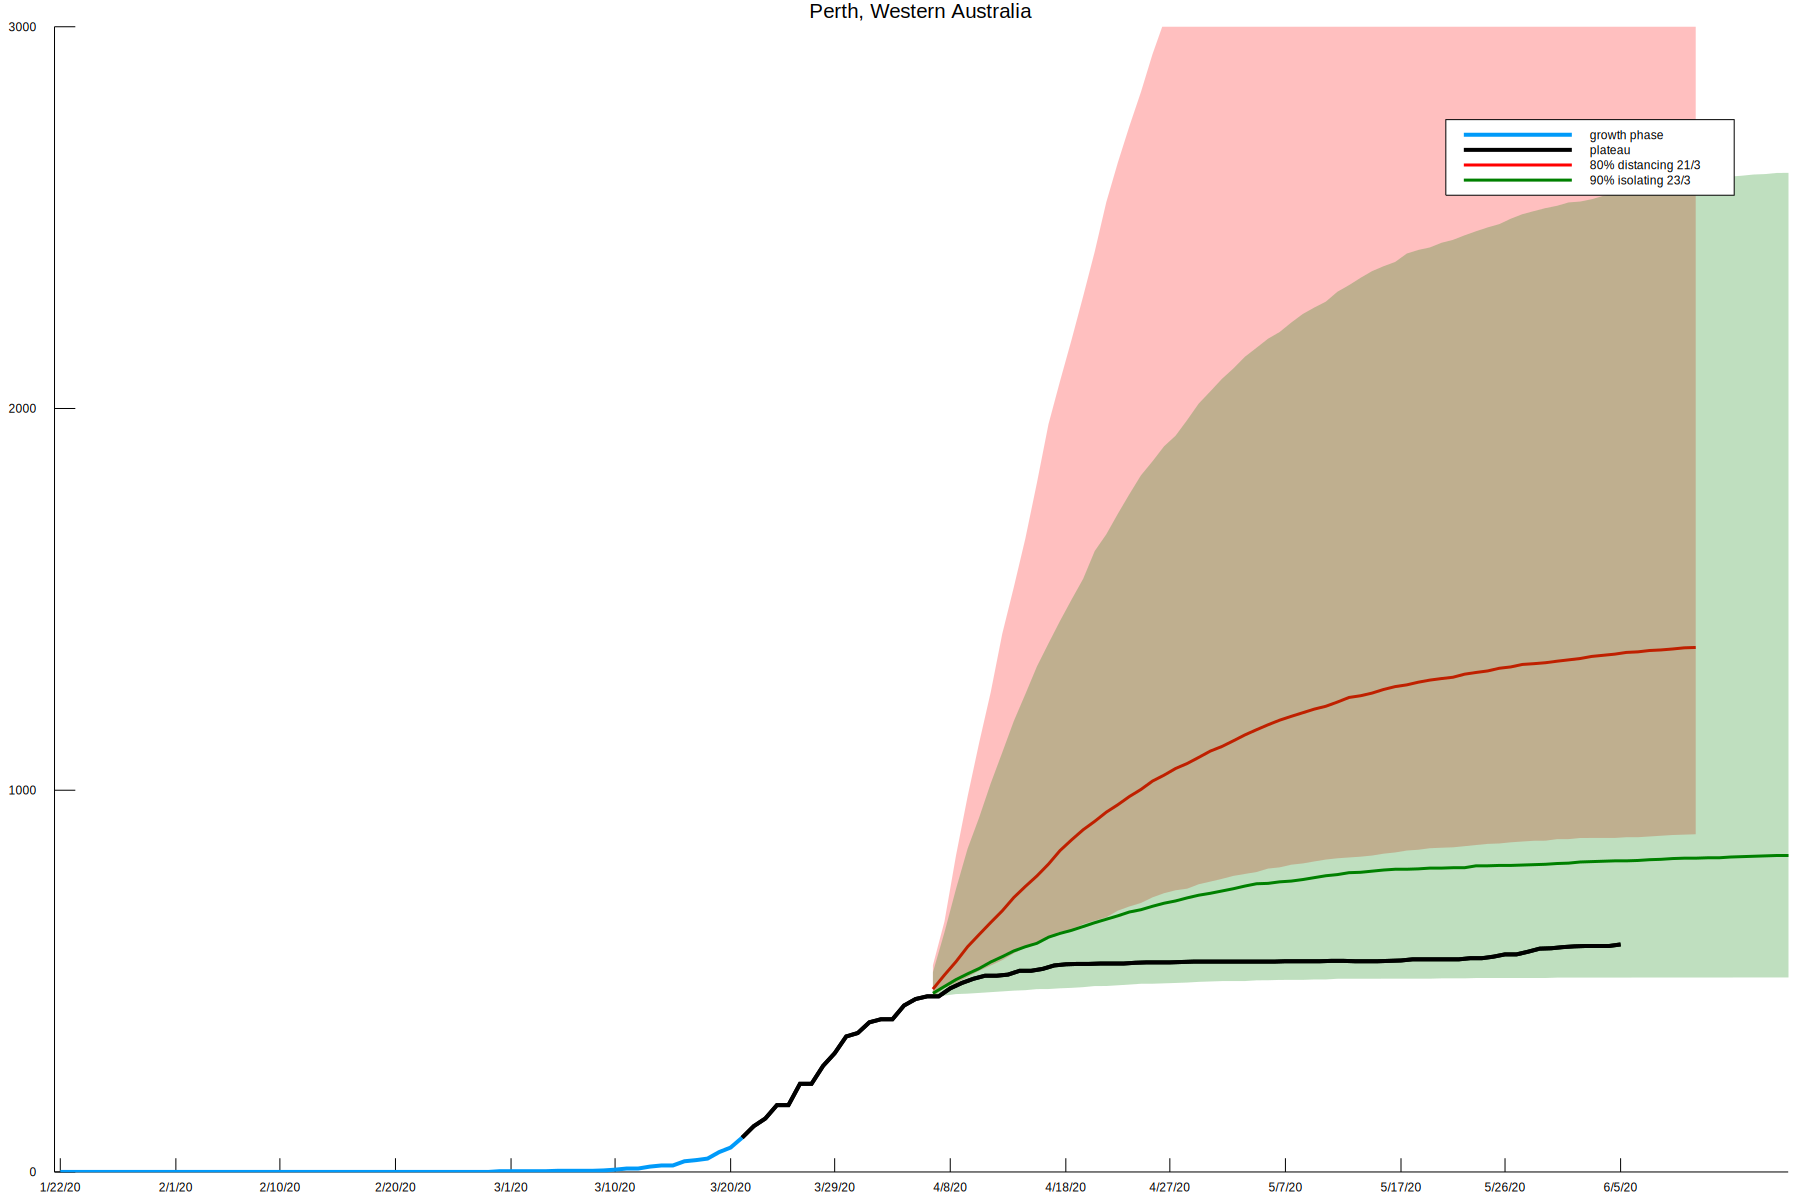

In [30]:
th=459 #number of active infecteds - this sets the day from which to make predicions
tp=count(x->x<th,y)
ddt(z,zt)=count(z->z>0, z[1:zt])+ count(z->z<0, z[zt+1:end])
~,tpday=findmax([ddt(diff(diff(y)),nx) for nx in 1:(ndays-2)])
#this is the turning point between exponential growth and decay. totItp total infections at day tpday
totItp=y[tpday+1]
plot(ddays[1:tpday+1],y[1:tpday+1],lw=4,label="growth phase",title="Perth, Western Australia",size=(1800,1200))
plot!(ddays[tpday+1:ndays],y[tpday+1:ndays],lw=4,seriescolor=:black,label="plateau")
(Sp,Ep,Ip,Rp) = EpiSim.epipred(th, St80,Et80,It80,Rt80)
lnp,~=size(Ip)
EpiSim.plotqnt((tp+1):tp+lnp,Ip+Rp,:red,"80% distancing 21/3")
(Sp,Ep,Ip,Rp) = EpiSim.epipred(th, St9,Et9,It9,Rt9)
lnp,~=size(Ip)
EpiSim.plotqnt((tp+1):tp+lnp,Ip+Rp,:green,"90% isolating 23/3")
plot!(ddays[tpday+1:ndays],y[tpday+1:ndays],lw=4,seriescolor=:black,label=false,xlimit=(0,150),ylimit=(0,3000))

In [31]:
using Statistics

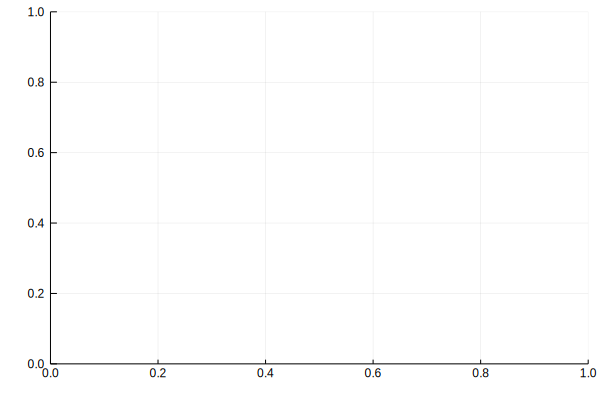

In [32]:
plot()

In [33]:
maximum(Int.(Ip))

540

In [34]:
RR = Rp[2:end,:] - Rp[1:end-1,:] ### daily increase of removed
II = RR+Ip[2:end,:]-Ip[1:(end-1),:] ### daily increase of infected
EE = II+Ep[2:end,:]-Ep[1:(end-1),:] ### daily increase of exposed
ET = Ep[2:end,:] ### current number of exposed

111×383 Array{UInt64,2}:
 0x00000000000000d1  0x000000000000004a  …  0x000000000000008a
 0x00000000000000c2  0x0000000000000048     0x0000000000000084
 0x00000000000000b9  0x0000000000000040     0x0000000000000084
 0x00000000000000ae  0x0000000000000042     0x0000000000000085
 0x00000000000000a2  0x000000000000003e     0x000000000000007a
 0x000000000000009f  0x000000000000003d  …  0x000000000000007e
 0x000000000000009e  0x000000000000003a     0x000000000000007a
 0x0000000000000098  0x0000000000000038     0x0000000000000074
 0x000000000000008e  0x0000000000000033     0x0000000000000076
 0x000000000000008b  0x0000000000000037     0x000000000000006e
 0x000000000000008c  0x0000000000000035  …  0x000000000000006b
 0x0000000000000088  0x0000000000000030     0x0000000000000067
 0x000000000000007a  0x0000000000000032     0x000000000000006a
                  ⋮                      ⋱  
 0x000000000000002a  0x000000000000000d     0x0000000000000028
 0x000000000000002a  0x000000000000000d  …  0x00

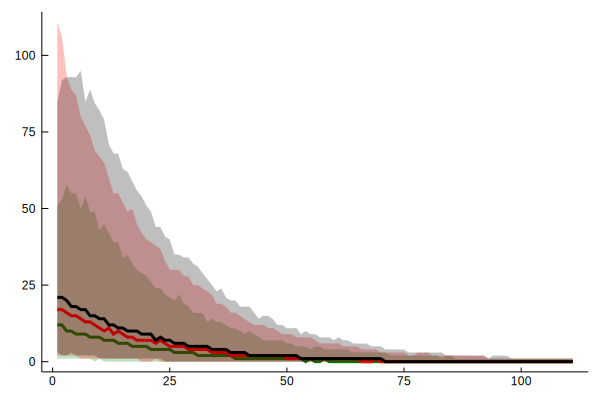

In [35]:
plot()
EpiSim.plotquantiles(EE,:green)
EpiSim.plotquantiles(II,:red)
EpiSim.plotquantiles(RR,:black)



In [36]:
plot(II,ET,seriestype=:scatter,legend=false,title="Hidden cases",xlabel="new infections", ylabel="total exposed",xlim=(0,100),ylim=(0, 600))

In [37]:
ninf=40
texp=300
hidden=zeros(Int64, texp+1, ninf+1)
(ndays,nsims)=size(II)
for i in 1:ndays
    for j in 1:nsims
        xi=II[i,j]
        xj=ET[i,j]
        if xi<ninf && xj<texp
            hidden[xj+1,xi+1] += 1
        end
    end
end
hidpdf=Array{Float64, 2}(undef, texp+1, ninf+1)
for i in 1:(ninf+1)
    hidpdf[:, i] = hidden[:, i] / sum(hidden[:, i])
end

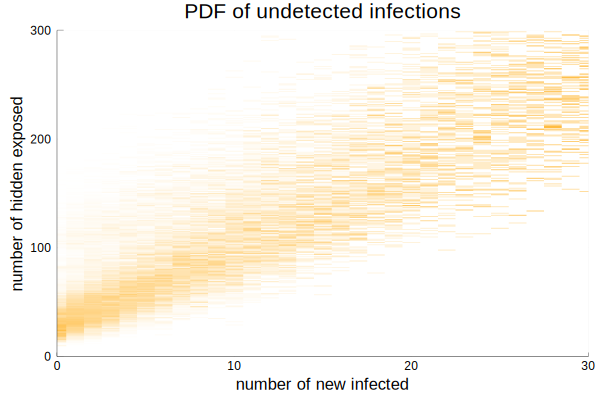

In [40]:
heatmap(0:40,0:300, hidpdf, title="PDF of undetected infections", xlabel="number of new infected", legend=false, ylabel="number of hidden exposed",ylim=(0,300), xlim=(0,30), color=cgrad([:white,:orange, :red], [0.1, 0.3, 0.8]) )

In [41]:
png("undetected-perth-nolegend.png")

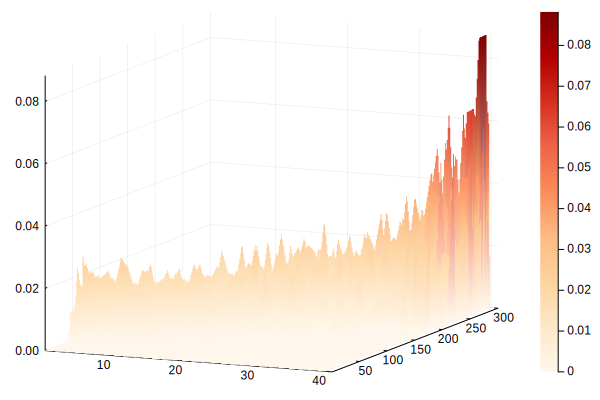

In [16]:
plot(hidpdf,seriestype=:surf, color=:OrRd)